In [65]:
import random
from base64 import b64decode
from json import loads
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
import sklearn
from scipy.stats import mode
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()  # for plot styling

In [66]:
def ler(x):

    digit = loads(x)
    array = np.fromstring(b64decode(digit["data"]),dtype=np.ubyte)
    array = array.astype(np.float64)
    return (digit["label"], array)

In [67]:
#Lemos o dataset e criamos uma lista com todos os valores
with open("digits.base64.json","r") as f:
    digits = map(ler, f.readlines())
digits=list(digits)

In [68]:
#Definimos uma função que transforma os vetores com os pixeis em uma imagem
#com o digito
def display_digit(digit, labeled = True, title = ""):
    if labeled:
        digit = digit[1]
    image = digit
    plt.figure()
    fig = plt.imshow(image.reshape(28,28))
    fig.set_cmap('gray_r')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    if title != "":
        plt.title("Inferred label: " + str(title))

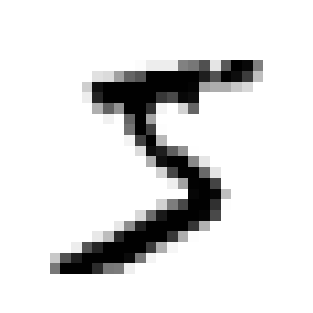

In [69]:
display_digit(digits[0])

In [70]:
#Criamos uma nova lista que armazenará apenas a informação dos pixeis
#de cada dígito
new_digits=[]
cont=0
while cont<len(digits):
    new_digits.append(digits[cont][1])
    cont+=1

In [71]:
digits_treino=digits[:len(digits)*5//6]
digits_val=digits[len(digits)*5//6:]
new_digits_treino=new_digits[:len(new_digits)*5//6]
new_digits_val=new_digits[len(new_digits)*5//6:]

In [72]:
#Usamos o KMeans do sklearn para descobrir as clusters
n=10
kmeans = KMeans(n_clusters=n)
kmeans.fit(new_digits)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [73]:
#Criamos uma lista com o index da cluster à qual cada dígito pertence
#Criamos também uma lista com os centros de cada cluster
clus=kmeans.predict(new_digits)
centers = kmeans.cluster_centers_
clus

array([0, 4, 2, ..., 0, 7, 7])

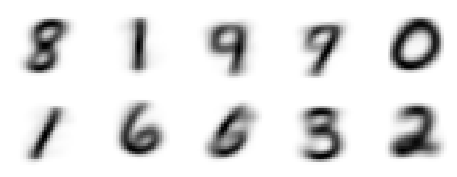

In [74]:
#Encontramos os pontos mais próximos dos centros de cada cluster e plotamos eles,
#para que seja possível ter uma ideia da forma dos números que estão em cada
#cluster. Idealmente, cada cluster só conteria dígitos que são os mesmos que seus
#centros
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = centers.reshape(10, 28, 28)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

In [75]:
def acha_nome(i):
    valores=[0,0,0,0,0,0,0,0,0,0]
    cont=0
    while cont<len(digits_treino):
        if clus[cont]==i:
            valores[digits_treino[cont][0]]=valores[digits_treino[cont][0]]+1
        cont=cont+1
    m=max(valores)
    cont=0
    while cont<len(valores):
        if m==valores[cont]:
            return cont
        cont=cont+1

In [76]:
#Utilizamos a função para encontrar o dígito mais frequente, usando apenas
#aqueles que estão na lista digits_treino. Nomeamos a cluster com esse dígito.
#Criamos a lista valores que, ao receber o index da cluster, retorna seu nome
nomes=np.arange(0,n)
cont=0
while cont<len(nomes):
    nomes[cont]=acha_nome(cont)
    cont=cont+1
nomes

array([8, 1, 4, 7, 0, 1, 6, 6, 3, 2])

In [77]:
#Agora, com as clusters nomeadas, utilizaremos a lista digits_val para conferir 
#o real valor do dígito com o nome da cluster a ele associado
gt=[]
clus_nome=[]
cont=0
while cont<len(digits_val):
    gt.append(digits_val[cont][0])
    clus_nome.append(nomes[clus[cont+50000]])
    cont=cont+1

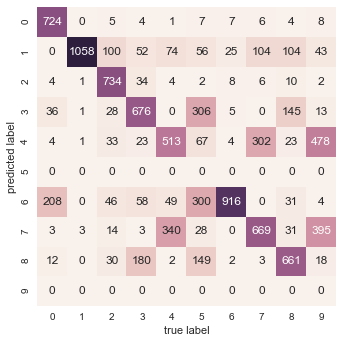

In [78]:
#Criamos uma confusion matrix, que nos mostra os erros e acertos das clusters
mat = confusion_matrix(gt, clus_nome)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.arange(0,10),
            yticklabels=np.arange(0,10))
plt.xlabel('true label')
plt.ylabel('predicted label');

In [79]:
#Escrevemos, agora, um código que nos dirá a porcentamge dos acertos
def taxa(mat):
    acertos=0
    cont=0
    while cont<10:
        acertos += mat[cont][cont]
        cont += 1
    taxa = acertos/10000
    return taxa

In [80]:
taxa(mat)

0.59509999999999996

Vemos, assim, que nosso programa já é capaz de agrupar os dígitos na maior parte das vezes. Ainda podemos, no entanto, melhorar bastante sua performance. Olhando para a confusion matrix, é fácil perceber um grave problema: cincos e noves nunca foram corretamente classificados. Olhando para a lista com os "nomes" dos clusters e para as imagens dos centros, encontramos o motivo: nenhuma cluster foi classificada como "5" ou como "9", apesar de dois dos centros serem noves. As clusters desses centros receberam os nomes de 7 e 4, que de fato se assemelham à forma dos noves da imagem. Também vemos que dois dos centros são uns e outros dois são zeros. Isso ocorre porque existem mais do que uma forma de desenhar certos dígitos. Nossa decisão inicial de aplicar o k-means com apenas 10 clusters acabou comprometendo a performance do programa.

Fazemos, a seguir, um estudo de performance em relação ao número de clusters:

In [81]:
n=10
perf=[]
while n<51:
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(new_digits)
    clus=kmeans.predict(new_digits)
    nomes=np.arange(0,n)
    cont=0
    while cont<len(nomes):
        nomes[cont]=acha_nome(cont)
        cont=cont+1
    gt=[]
    clus_nome=[]
    cont=0
    while cont<len(digits_val):
        gt.append(digits_val[cont][0])
        clus_nome.append(nomes[clus[cont+50000]])
        cont=cont+1
    mat = confusion_matrix(gt, clus_nome)
    perf.append(taxa(mat))
    n+=1
perf

[0.60229999999999995,
 0.60309999999999997,
 0.61629999999999996,
 0.63149999999999995,
 0.67259999999999998,
 0.69210000000000005,
 0.70199999999999996,
 0.72199999999999998,
 0.71830000000000005,
 0.72440000000000004,
 0.72640000000000005,
 0.73070000000000002,
 0.74099999999999999,
 0.72740000000000005,
 0.74990000000000001,
 0.75439999999999996,
 0.75649999999999995,
 0.76459999999999995,
 0.76880000000000004,
 0.76990000000000003,
 0.77810000000000001,
 0.77100000000000002,
 0.77100000000000002,
 0.78969999999999996,
 0.77390000000000003,
 0.79459999999999997,
 0.77080000000000004,
 0.79920000000000002,
 0.81030000000000002,
 0.80430000000000001,
 0.81820000000000004,
 0.81320000000000003,
 0.82020000000000004,
 0.81279999999999997,
 0.82050000000000001,
 0.81189999999999996,
 0.82999999999999996,
 0.82369999999999999,
 0.82930000000000004,
 0.83220000000000005,
 0.82050000000000001]

In [83]:
n=60
perf2=[]
while n<101:
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(new_digits)
    clus=kmeans.predict(new_digits)
    nomes=np.arange(0,n)
    cont=0
    while cont<len(nomes):
        nomes[cont]=acha_nome(cont)
        cont=cont+1
    gt=[]
    clus_nome=[]
    cont=0
    while cont<len(digits_val):
        gt.append(digits_val[cont][0])
        clus_nome.append(nomes[clus[cont+50000]])
        cont=cont+1
    mat = confusion_matrix(gt, clus_nome)
    perf2.append(taxa(mat))
    n+=10
perf2

[0.85350000000000004,
 0.87050000000000005,
 0.88539999999999996,
 0.87860000000000005,
 0.88880000000000003]

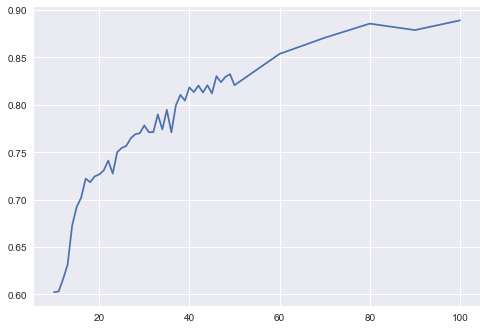

In [91]:
perf3=perf+perf2
a=np.arange(10,51)
b=np.arange(60,110,10)
c=list(a)+list(b)
plt.plot(c,perf3)

Nosso estudo nos mostra que à medida que aumentamos o número de clusters, a 
performance melhora, sem limite aparente. Ao considerar 100 clusters para o
algorítmo, a performance foi bem superior, chegando a quase 88%

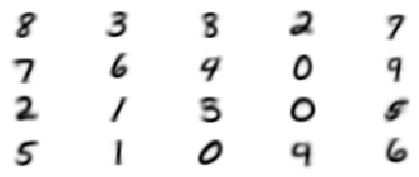

In [92]:
n=20
kmeans = KMeans(n_clusters=n)
kmeans.fit(new_digits)
clus=kmeans.predict(new_digits)
centers = kmeans.cluster_centers_
fig, ax = plt.subplots(4, 5, figsize=(8, 3))
centers = centers.reshape(20, 28, 28)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

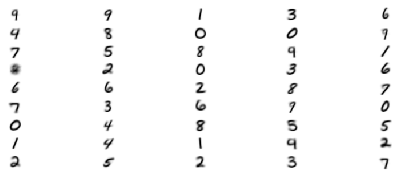

In [93]:
n=45
kmeans = KMeans(n_clusters=n)
kmeans.fit(new_digits)
clus=kmeans.predict(new_digits)
centers = kmeans.cluster_centers_
fig, ax = plt.subplots(9, 5, figsize=(8, 3))
centers = centers.reshape(45, 28, 28)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)


Vemos aqui, para 45 clusters, os centros. De acordo com o que esperávamos, os 
centros parecem tomar a forma de jeitos comuns de se escrever cada dígito. 
Parece que à medida que tomamos mais e mais clusters para rodar o algorítmo,
obtemos mais centros que correspondem a uma forma específica de se escrever
cada dígito, assim aumentando a chance daquele dígito ser corretamente classificado.

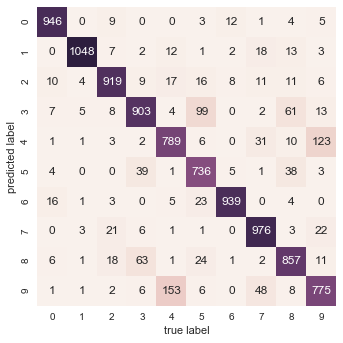

In [94]:
nomes=np.arange(0,n)
cont=0
while cont<len(nomes):
    nomes[cont]=acha_nome(cont)
    cont=cont+1
mat = confusion_matrix(gt, clus_nome)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.arange(0,10),
            yticklabels=np.arange(0,10))
plt.xlabel('true label')
plt.ylabel('predicted label');